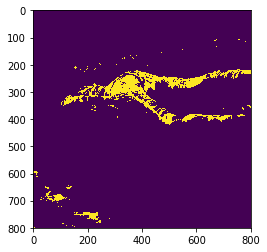

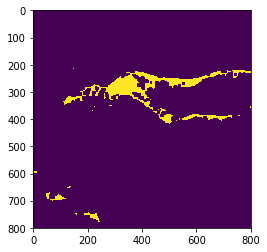

'\n%matplotlib inline\ndip.imshow(threshMap)\ndip.show()\n'

In [1]:
import cv2
import numpy as np
import dippykit as dip
import matplotlib.pyplot as plt
import pandas as pd


#PICKING AN IMAGE
im_original = cv2.imread("images/UW_400.png")
#im_original = cv2.imread("images/underwater-15.png")

#im_original = cv2.imread("images/24Zimmer-Refer-articleLarge.jpg")

#INITIAL EXPLORATION OF THE PICTURE

#Select pixels that are similar in color to skin
im_skin = np.copy(im_original)
for i in range(np.shape(im_original)[0]):
    for j in range(np.shape(im_original)[1]):
        #if im_original[i,j][2] < 60:
        if im_original[i,j][2] < 60 or im_original[i,j][0] > 200: #Zones mostly reddish, not blueish
            im_skin[i,j]=[0,0,0]

cv2.imwrite("temp_images/tree_morf/skin_color.png", im_skin)

#Select zones with high luminosity (probably zones iluminated by refracted light)
im_gray = cv2.cvtColor(im_original, cv2.COLOR_BGR2GRAY)
ret,th1 = cv2.threshold(im_gray,180,255,cv2.THRESH_BINARY)

kernel = np.ones((5,5),np.uint8)
binary_morf = cv2.morphologyEx(th1, cv2.MORPH_CLOSE, kernel)
#binary_morf = cv2.dilate(th1,kernel,iterations = 2)
#binary_morf = cv2.dilate(th1,kernel,iterations = 2)
binary_morf = cv2.erode(binary_morf,kernel,iterations = 1)
cv2.imwrite("temp_images/tree_morf/binary_morf.png", binary_morf )

"""
#Saliency detection
# initialize OpenCV's static fine grained saliency detector and compute the saliency map
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency.computeSaliency(im_original)

# if we would like a *binary* map that we could process for contours,
# compute convex hull's, extract bounding boxes, etc., we can
# additionally threshold the saliency map

threshMap = cv2.threshold(saliencyMap*255, 80, 255,cv2.THRESH_BINARY)[1]

cv2.imwrite("temp_images/saliency.png", saliencyMap*255)
"""

%matplotlib inline
dip.imshow(th1)
dip.show()

%matplotlib inline
dip.imshow(binary_morf)
dip.show()

"""
%matplotlib inline
dip.imshow(threshMap)
dip.show()
"""

In [2]:
"""
def reduce_mask(mask):

    N,M = np.shape(mask)
    WHITE = 255
    DARKEN_LAYER = 0

    for i in range(N):

        edge_detected = False
        for j in range(M):

            if mask[i][j] == WHITE and edge_detected == False:
                mask[i][j] = 0
                if j+DARKEN_LAYER<M:
                    for k in range(1,DARKEN_LAYER+1):
                        mask[i][j+k]=0

                if j+DARKEN_LAYER+1 == WHITE:
                    edge_detected = True

            elif mask[i][j] == 0 and edge_detected == True:
                mask[i][j-1] = 0
                edge_detected = False
                if j-DARKEN_LAYER>=0:
                    for k in range(1,DARKEN_LAYER+1):
                        mask[i][j-k]=0
                        
"""

In [3]:
#binary_morf

In [4]:
class Pixel(object):
    def __init__(self):
        self.position = None
        self.neighbors = None

In [12]:
#Interpolation without morfological operations

im_skin_interp = np.copy(im_skin)

#Step 1: Go over all the pixels of "Zones similar to skin color" using a square of 4 pixels

for i in range(np.shape(im_skin)[0] - 1):
    for j in range(np.shape(im_skin)[1] -1):
        
        pixel_upper_left = im_skin[i,j]
        pixel_upper_rigth = im_skin[i,j+1]
        pixel_bottom_left = im_skin[i+1 ,j]
        pixel_bottom_rigth = im_skin[i+1,j+1]
        
        pixel_array = [pixel_upper_left, pixel_upper_rigth, pixel_bottom_left, pixel_bottom_rigth]
        
        remove_pixel = [False, False, False, False]
        
                
        #Step 2: Check if at least one of the 4 pixels correspond to the body (i.e. it isn´t black)
        
        if (pixel_upper_left > ([0, 0, 0])).all() or (pixel_upper_rigth > ([0,0,0])).all or (pixel_bottom_left > ([0,0,0])).all() or (pixel_bottom_rigth > ([0,0,0])).all():
            
            #Step 3: Check if any of those pixels are marked as pixels to remove (i.e. they are white on image after binary threshold)
            if th1[i,j] == 255: 
                remove_pixel[0] = True
            if th1[i,j+1] == 255: 
                remove_pixel[1] = True
            if th1[i+1,j] == 255: 
                remove_pixel[2] = True
            if th1[i+1,j+1] == 255: 
                remove_pixel[3] = True
            
            #We need to remove the targeted pixels and substitute its value with the average of the surrounding pixels that are part of the body
            
            aux_pixel_value = [0,0,0]
            num_pixels_for_average = 0
            
            for p in range(np.shape(pixel_array)[0]):
                #if remove_pixel[p] == False and (pixel_array[p] > ([0, 0, 0])).all(): 
                if remove_pixel[p] == False: #Using this condition, the image has less false skin-coloured pixels
                    aux_pixel_value = aux_pixel_value + pixel_array[p]
                    num_pixels_for_average = num_pixels_for_average + 1
                    
            if num_pixels_for_average > 0: 
                avg_pixel_value = aux_pixel_value/num_pixels_for_average
            elif num_pixels_for_average == 0:
                avg_pixel_value = (255,0,0)
                
            
            for p in range(np.shape(pixel_array)[0]):
                if remove_pixel[p] == True: 
                    pixel_array[p] =  avg_pixel_value
                   
            if (im_skin[i,j] == [0,0,0]).all():
                im_skin_interp[i,j] = pixel_array[0]
            if (im_skin[i,j+1] == [0,0,0]).all():
                im_skin_interp[i,j+1] = pixel_array[1]
            if (im_skin[i+1,j] == [0,0,0]).all():
                im_skin_interp[i+1 ,j] = pixel_array[2]
            if (im_skin[i+1,j+1] == [0,0,0]).all():
                im_skin_interp[i+1,j+1] = pixel_array[3]
            """
            
            im_skin_interp[i,j] = pixel_array[0]
            im_skin_interp[i,j+1] = pixel_array[1]
            im_skin_interp[i+1,j] = pixel_array[2]
            im_skin_interp[i+1,j+1] = pixel_array[3]
            
            """ 
            
cv2.imwrite("temp_images/tree_morf/skin_color_interpolated.png", im_skin_interp)           
            


True

In [13]:
#Interpolation with morfological operations

im_skin_interp_morf = np.copy(im_skin)

#Step 1: Go over all the pixels of "Zones similar to skin color" using a square of 4 pixels

for i in range(np.shape(im_skin)[0] - 1):
    for j in range(np.shape(im_skin)[1] -1):
        
        pixel_upper_left = im_skin[i,j]
        pixel_upper_rigth = im_skin[i,j+1]
        pixel_bottom_left = im_skin[i+1 ,j]
        pixel_bottom_rigth = im_skin[i+1,j+1]
        
        pixel_array = [pixel_upper_left, pixel_upper_rigth, pixel_bottom_left, pixel_bottom_rigth]
        
        remove_pixel = [False, False, False, False]
        
                
        #Step 2: Check if at least one of the 4 pixels correspond to the body (i.e. it isn´t black)
        
        if (pixel_upper_left > ([0, 0, 0])).all() or (pixel_upper_rigth > ([0,0,0])).all or (pixel_bottom_left > ([0,0,0])).all() or (pixel_bottom_rigth > ([0,0,0])).all():
            
            #Step 3: Check if any of those pixels are marked as pixels to remove (i.e. they are white on image after binary threshold)
            if binary_morf[i,j] == 255: 
                remove_pixel[0] = True
            if binary_morf[i,j+1] == 255: 
                remove_pixel[1] = True
            if binary_morf[i+1,j] == 255: 
                remove_pixel[2] = True
            if binary_morf[i+1,j+1] == 255: 
                remove_pixel[3] = True
            
            #We need to remove the targeted pixels and substitute its value with the average of the surrounding pixels that are part of the body
            
            aux_pixel_value = [0,0,0]
            num_pixels_for_average = 0
            
            for p in range(np.shape(pixel_array)[0]):
                #if remove_pixel[p] == False and (pixel_array[p] > ([0, 0, 0])).all(): 
                if remove_pixel[p] == False: #Using this condition, the image has less false skin-coloured pixels
                    aux_pixel_value = aux_pixel_value + pixel_array[p]
                    num_pixels_for_average = num_pixels_for_average + 1
                    
            if num_pixels_for_average > 0: 
                avg_pixel_value = aux_pixel_value/num_pixels_for_average
            elif num_pixels_for_average == 0:
                avg_pixel_value = (255,0,0)
                
            
            for p in range(np.shape(pixel_array)[0]):
                if remove_pixel[p] == True: 
                    pixel_array[p] =  avg_pixel_value
            """        
            if (im_skin[i,j] == [0,0,0]).all():
                im_skin_interp[i,j] = pixel_array[0]
            if (im_skin[i,j+1] == [0,0,0]).all():
                im_skin_interp[i,j+1] = pixel_array[1]
            if (im_skin[i+1,j] == [0,0,0]).all():
                im_skin_interp[i+1 ,j] = pixel_array[2]
            if (im_skin[i+1,j+1] == [0,0,0]).all():
                im_skin_interp[i+1,j+1] = pixel_array[3]
            """
            
            im_skin_interp_morf[i,j] = pixel_array[0]
            im_skin_interp_morf[i,j+1] = pixel_array[1]
            im_skin_interp_morf[i+1,j] = pixel_array[2]
            im_skin_interp_morf[i+1,j+1] = pixel_array[3]
            
            
cv2.imwrite("temp_images/tree_morf/skin_color_interpolated_morf.png", im_skin_interp_morf)           
            


True

In [6]:
#Adding red pixels to the list of pixels to fix. The red pixels are those that couldn be interpolated

list_pixels_to_fix = []

    
for i in range(np.shape(im_skin)[0] - 1):
    for j in range(np.shape(im_skin)[1] -1):
        if (im_skin_interp[i,j] == ([255,0,0])).all():
           
            list_pixels_to_fix.append((i,j))

print(list_pixels_to_fix)


[(211, 153), (212, 152), (212, 153), (220, 752), (220, 753), (220, 754), (221, 373), (221, 374), (221, 743), (221, 744), (221, 745), (221, 746), (221, 747), (221, 748), (221, 749), (221, 750), (221, 751), (221, 752), (221, 753), (221, 754), (221, 755), (221, 756), (221, 757), (221, 758), (221, 759), (221, 760), (221, 761), (221, 762), (221, 763), (221, 764), (221, 765), (221, 766), (221, 767), (221, 768), (221, 769), (221, 770), (222, 373), (222, 374), (222, 712), (222, 713), (222, 730), (222, 731), (222, 732), (222, 733), (222, 734), (222, 735), (222, 736), (222, 737), (222, 738), (222, 739), (222, 740), (222, 741), (222, 742), (222, 743), (222, 744), (222, 745), (222, 746), (222, 747), (222, 748), (222, 749), (222, 750), (222, 751), (222, 752), (222, 753), (222, 754), (222, 755), (222, 756), (222, 757), (222, 758), (222, 759), (222, 760), (222, 761), (222, 762), (222, 763), (222, 764), (222, 765), (222, 766), (222, 767), (222, 768), (222, 769), (222, 770), (222, 771), (222, 772), (22

In [7]:
#This block is to find the first order pixels in the first iteration

"""

num_pixel = 0

list_pixels_first_order = []

for item in list_pixels_to_fix: 
        
        # i and j are the coordinates of each red pixel
        i = item[0]
        j = item[1]
        
        initialization_pixel = 0 #That means that the pixel has not been added yet to the list of first order pixels
        
        for row in range(i-1, i+2):
            for col in range(j-1, j+2): 
                #Here it checks if some of the surrounding pixels are not equal to red (i.e. has skin color)
                if (im_skin_interp[row,col] != ([255,0,0])).all():
                    
                    if initialization_pixel == 0: 
                        #the first time, it is created a structure inside the list and the position is registered 
                        #the list of neighbors is initialized
                        list_pixels_first_order.append(num_pixel)
                        list_pixels_first_order[num_pixel] = Pixel()
                        list_pixels_first_order[num_pixel].position = (i,j)
                        list_pixels_first_order[num_pixel].neighbors = []
                        
                        initialization_pixel = 1
                        num_pixel = num_pixel + 1
                    
                    list_pixels_first_order[num_pixel-1].neighbors.append((row,col))
        
        initialization_pixel = 0       
                    
print(list_pixels_first_order[0].position)
print(list_pixels_first_order[0].neighbors)

"""

'\n\nnum_pixel = 0\n\nlist_pixels_first_order = []\n\nfor item in list_pixels_to_fix: \n        \n        # i and j are the coordinates of each red pixel\n        i = item[0]\n        j = item[1]\n        \n        initialization_pixel = 0 #That means that the pixel has not been added yet to the list of first order pixels\n        \n        for row in range(i-1, i+2):\n            for col in range(j-1, j+2): \n                #Here it checks if some of the surrounding pixels are not equal to red (i.e. has skin color)\n                if (im_skin_interp[row,col] != ([255,0,0])).all():\n                    \n                    if initialization_pixel == 0: \n                        #the first time, it is created a structure inside the list and the position is registered \n                        #the list of neighbors is initialized\n                        list_pixels_first_order.append(num_pixel)\n                        list_pixels_first_order[num_pixel] = Pixel()\n                  

In [8]:
#This block is to paint in green those pixels that are considered as first order pixels on the first iteration

"""
for item in list_pixels_first_order:
    # i and j are the coordinates of each first order pixel
    i = item.position[0]
    j = item.position[1]
    
    im_skin_interp[i,j] = [0, 255, 0]
    
%matplotlib inline
dip.imshow(im_skin_interp)
dip.show()

cv2.imwrite("temp_images/skin_color_interpolated_first_order_morf.png", im_skin_interp)

"""

'\nfor item in list_pixels_first_order:\n    # i and j are the coordinates of each first order pixel\n    i = item.position[0]\n    j = item.position[1]\n    \n    im_skin_interp[i,j] = [0, 255, 0]\n    \n%matplotlib inline\ndip.imshow(im_skin_interp)\ndip.show()\n\ncv2.imwrite("temp_images/skin_color_interpolated_first_order_morf.png", im_skin_interp)\n\n'

In [9]:
#This block paints the first order pixels of the first iteration with the average color of the neighbor pixels

"""

for item in list_pixels_first_order:
    # i and j are the coordinates of each first order pixel
    i = item.position[0]
    j = item.position[1]
    #print(sum(np.array(item.neighbors)))
    
    aux_rgb = (0,0,0)
    
    for neighbor in item.neighbors: 
        row = neighbor[0]
        col = neighbor[1]
        
        aux_rgb = aux_rgb + im_skin_interp[row,col]
    
    im_skin_interp[i,j] = aux_rgb/len(item.neighbors)
    print(aux_rgb)
    print(len(item.neighbors))
    print(im_skin_interp[i,j])
    
%matplotlib inline
dip.imshow(im_skin_interp)
dip.show()

cv2.imwrite("temp_images/skin_color_interpolated_first_order_first_stage.png", im_skin_interp)

"""

'\n\nfor item in list_pixels_first_order:\n    # i and j are the coordinates of each first order pixel\n    i = item.position[0]\n    j = item.position[1]\n    #print(sum(np.array(item.neighbors)))\n    \n    aux_rgb = (0,0,0)\n    \n    for neighbor in item.neighbors: \n        row = neighbor[0]\n        col = neighbor[1]\n        \n        aux_rgb = aux_rgb + im_skin_interp[row,col]\n    \n    im_skin_interp[i,j] = aux_rgb/len(item.neighbors)\n    print(aux_rgb)\n    print(len(item.neighbors))\n    print(im_skin_interp[i,j])\n    \n%matplotlib inline\ndip.imshow(im_skin_interp)\ndip.show()\n\ncv2.imwrite("temp_images/skin_color_interpolated_first_order_first_stage.png", im_skin_interp)\n\n'

Ratio: 0


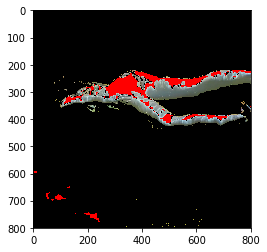

Ratio: 0.8783183750590459


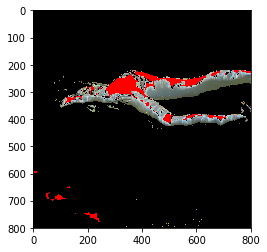

Ratio: 0.7616438356164383


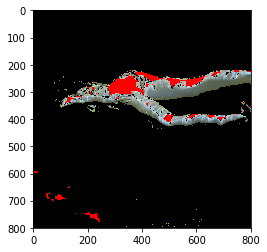

Ratio: 0.6554558337269721


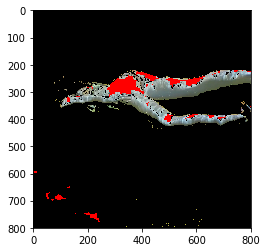

Ratio: 0.5633443552196504


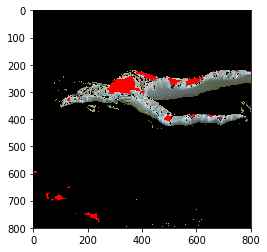

Ratio: 0.48804912612187057


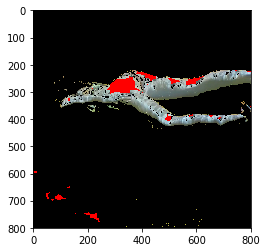

Ratio: 0.4276334435521965


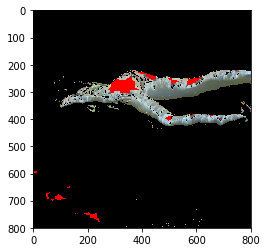

Ratio: 0.37803495512517715


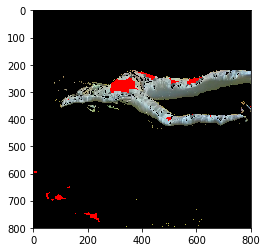

Ratio: 0.33665564478034954


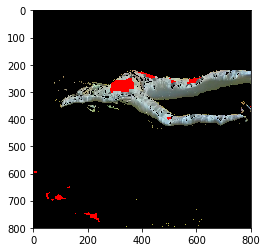

Ratio: 0.301936702881436


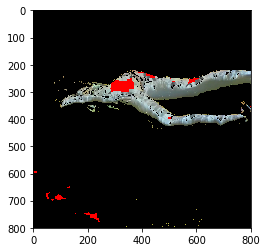

Ratio: 0.2728389230042513


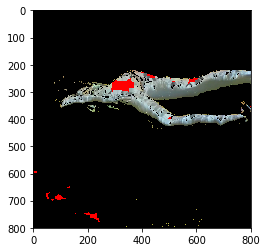

Ratio: 0.24747283892300426


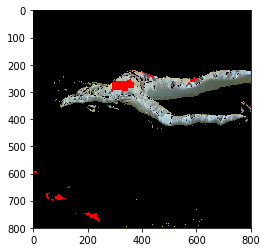

Ratio: 0.22508266414737838


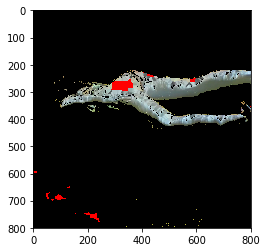

Ratio: 0.20590458195559755


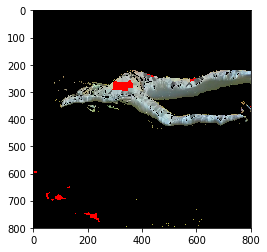

Ratio: 0.19003306565895134


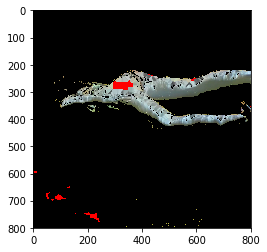

Ratio: 0.17543693906471422


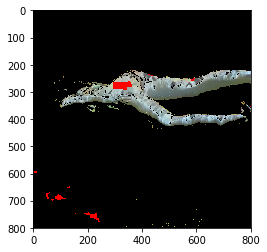

Ratio: 0.16188001889466225


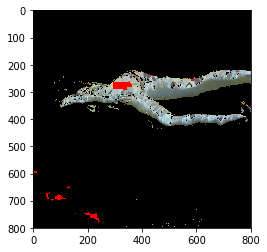

Ratio: 0.14922059518186112


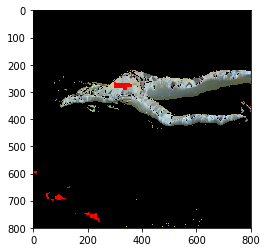

Ratio: 0.1377420878601795


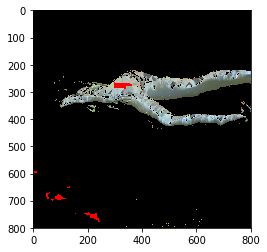

Ratio: 0.12744449692961737


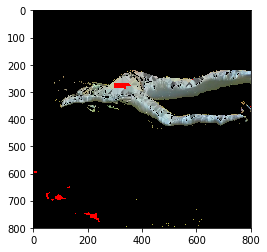

Ratio: 0.11842229570146434


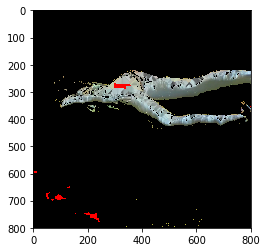

Ratio: 0.11006140765233821


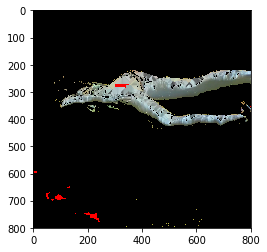

Ratio: 0.1024090694378838


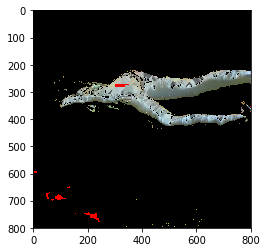

Ratio: 0.09551251771374587


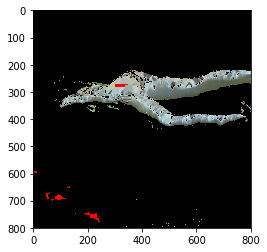

Ratio: 0.0894189891355692


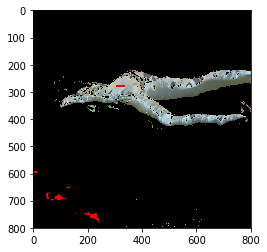

Ratio: 0.08427019367028814


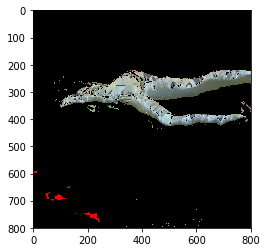

Ratio: 0.08058573452999528


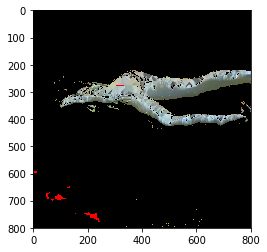

Ratio: 0.07727916863486065


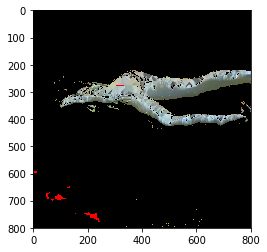

Ratio: 0.07435049598488427


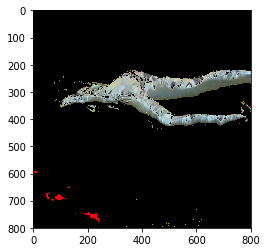

Ratio: 0.07302786962683042


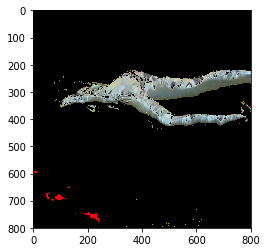

Completed


True

In [10]:
#Iterative method: after selecting the pixels to fix, this block iteratively find the first order pixels 
#in each iteration and paints them averaging the color of the neighbors 


num_total_pix_to_fix = len(list_pixels_to_fix)
num_current_pixels_to_fix = len(list_pixels_to_fix)

#ratio_old = num_current_pixels_to_fix/num_total_pix_to_fix
ratio_new = 0

while True: 
    
    #Step 1: Find which pixels are first order pixels from those we still need to fix
    num_pixel = 0

    list_pixels_first_order = []
    ratio_old = num_current_pixels_to_fix/num_total_pix_to_fix
    
    print("Ratio: " + str(ratio_new))
    
    for item in list_pixels_to_fix: 
        
        # i and j are the coordinates of each red pixel
        i = item[0]
        j = item[1]
        
        initialization_pixel = 0 #That means that the pixel has not been added yet to the list of first order pixels
        
        for row in range(i-1, i+2):
            for col in range(j-1, j+2): 
                #Here it checks if some of the surrounding pixels are not equal to red (i.e. has skin color)
                if (im_skin_interp[row,col] != ([255,0,0])).all():
                    
                    if initialization_pixel == 0: 
                        #the first time, it is created a structure inside the list and the position is registered 
                        #the list of neighbors is initialized
                        list_pixels_first_order.append(num_pixel)
                        list_pixels_first_order[num_pixel] = Pixel()
                        list_pixels_first_order[num_pixel].position = (i,j)
                        list_pixels_first_order[num_pixel].neighbors = []
                        
                        initialization_pixel = 1
                        num_pixel = num_pixel + 1
                    
                    list_pixels_first_order[num_pixel-1].neighbors.append((row,col))
        
        initialization_pixel = 0   
        
        
    #Step 2: Interpolate those first order pixels
    
    for item in list_pixels_first_order:
        # i and j are the coordinates of each first order pixel
        i = item.position[0]
        j = item.position[1]
        #print(sum(np.array(item.neighbors)))

        aux_rgb = (0,0,0)

        for neighbor in item.neighbors: 
            row = neighbor[0]
            col = neighbor[1]

            aux_rgb = aux_rgb + im_skin_interp[row,col]

        im_skin_interp[i,j] = aux_rgb/len(item.neighbors)
        #print(aux_rgb)
        #print(len(item.neighbors))
        #print(im_skin_interp[i,j])
        
        list_pixels_to_fix.remove((i,j))

    num_current_pixels_to_fix = len(list_pixels_to_fix)
    
    ratio_new = num_current_pixels_to_fix/num_total_pix_to_fix
    
    %matplotlib inline
    dip.imshow(im_skin_interp)
    dip.show()
    
    #cv2.imwrite("temp_images/tree_morf/skin_color_interpolated_first_order_last_stage_morf.png", im_skin_interp)
    if len(list_pixels_to_fix) == [] or ratio_old == ratio_new:
        print("Completed")
        break
        
"""
%matplotlib inline
dip.imshow(im_skin_interp)
dip.show()
"""   
    
cv2.imwrite("temp_images/tree_morf/skin_color_interpolated_first_order_last_stage.png", im_skin_interp)

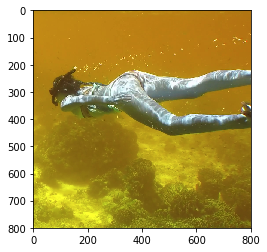

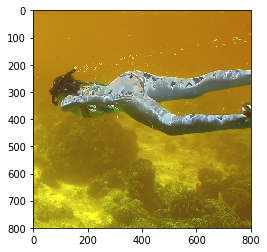

True

In [11]:
#Copying interpolated skin onto the original picture

im_res = np.copy(im_original)

%matplotlib inline
dip.imshow(im_original)
dip.show()

for i in range(np.shape(im_res)[0]):
    for j in range(np.shape(im_res)[1]):
        if (im_skin_interp[i,j] > [0, 0, 0]).all():
            im_res[i,j] = im_skin_interp[i,j]
            
%matplotlib inline
dip.imshow(im_res)
dip.show()

cv2.imwrite("temp_images/tree_morf/result.png", im_res)